In [1]:
#import
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np 
import datetime
from scipy import stats 
from datetime import datetime, timedelta
import time
import sklearn as sk
import nltk
import sqlite3
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
import random

In [8]:
#import data and review content
conn = sqlite3.connect('JobDBa.db')
cur = conn.cursor()
#21000 job descriptions at this time
cur.execute('SELECT * FROM [Jobs Indeed]')
data = cur.fetchall()
dfa = pd.DataFrame(data=data, columns=['Job Title', 'Company','Location','Description'])
print(dfa.describe())
dfa.isna().sum()

             Job Title          Company     Location  \
count            21187            21187        21187   
unique           14419             7719         1250   
top     Data Scientist  JP Morgan Chase  Toronto, ON   
freq               470              403          968   

                                              Description  
count                                               21187  
unique                                              21187  
top     Job Summary$18/hr + Commission ($12 while in t...  
freq                                                    1  


Job Title      0
Company        0
Location       0
Description    0
dtype: int64

**From initial observations on the dataset, there have been no issues with the scraper getting all intact data from indeed. There are no missing values for any of the scraped information categories. The current dataset has 21,000 unique job descriptions to perform clustering on.** 

In [3]:
#language processing by removing stop words, punctuation and perform vectorization
punc = ['.',',','"','?', '!', ':',';','(',')','[',']','{','}','%','$','#','@','&','*',"'"] #remove punctuation for initial analysis
stop_words = text.ENGLISH_STOP_WORDS.union(punc)
desc = dfa['Description'].values
vectorizer = TfidfVectorizer(stop_words = stop_words)
X = vectorizer.fit_transform(desc)
word_features = vectorizer.get_feature_names()
print(len(word_features))

89683


In [3]:
stemmer = SnowballStemmer('english')
punc = ['.',',','"','?', '!', ':',';','(',')','[',']','{','}','%','$','#','@','&','*',"'", "-", "--", "_", "__", " ", ""] #remove punctuation for initial analysis
stop_words = text.ENGLISH_STOP_WORDS.union(punc)
stopw = nltk.corpus.stopwords.words('english')
stop_words = stop_words.union(stopw)
def tokenize(txt):
    return [stemmer.stem(word) for word in word_tokenize(txt.lower())]

In [6]:
dftok = dfa.copy()
tok = []
lem = []
stem = []
stop = []
stopstem = []
for index,row in dftok.iterrows():
    x = word_tokenize(row['Description'])
    y = [lemma.lemmatize(word) for word in word_tokenize(row['Description'].lower())]
    z = [stemmer.stem(word) for word in word_tokenize(row['Description'].lower())]
    h = [n for n in word_tokenize(row['Description'].lower()) if not n in stop_words]
    e = [stemmer.stem(word) for word in h]
    tok.append(x)
    lem.append(y)
    stem.append(z)
    stop.append(h)
    stopstem.append(e)

In [7]:
dftok['Description Token'] = tok
dftok['Description Lem'] = lem
dftok['Description Stem'] = stem
dftok['Description Stop'] = stop
dftok['Description Stopstem']=stopstem
dftok.head(5)
#show different transformation's effect on language data

Job Title          Company       Location  \
0  Data Analyst - Energy Savings Programs  Ecotagious Inc.  Vancouver, BC   
1                          Head of Growth         Hostaway    Toronto, ON   
2     Field Sales Trainer: Eastern Canada        JUUL Labs    Toronto, ON   
3                          Cloud Engineer    Dialpad, Inc.  Vancouver, BC   
4                         SEO/SEM Manager          Patsnap    Toronto, ON   

                                         Description  \
0  Ecotagious is a cleantech software company cur...   
1  Hostaway is the fastest-growing global SaaS st...   
2  --------------------------------\nSr Manager, ...   
3  Dialpad's product suite covers the full range ...   
4  PatSnap vision\nPatSnap is a global, hyper-gro...   

                                   Description Token  \
0  [Ecotagious, is, a, cleantech, software, compa...   
1  [Hostaway, is, the, fastest-growing, global, S...   
2  [--, --, --, --, --, --, --, --, --, --, --, -...   
3  [Dialpad, 's, product, suite, covers, the, ful...   
4  [PatSnap, vision, PatSnap, is, a, global, ,, h...   

                                     Description Lem  \
0  [ecotagious, is, a, cleantech, software, compa...   
1  [hostaway, is, the, fastest-growing, global, s...   
2  [--, --, --, --, --, --, --, --, --, --, --, -...   
3  [dialpad, 's, product, suite, cover, the, full...   
4  [patsnap, vision, patsnap, is, a, global, ,, h...   

                                    Description Stem  \
0  [ecotagi, is, a, cleantech, softwar, compani, ...   
1  [hostaway, is, the, fastest-grow, global, saa,...   
2  [--, --, --, --, --, --, --, --, --, --, --, -...   
3  [dialpad, 's, product, suit, cover, the, full,...   
4  [patsnap, vision, patsnap, is, a, global, ,, h...   

                                    Description Stop  \
0  [ecotagious, cleantech, software, company, cur...   
1  [hostaway, fastest-growing, global, saas, star...   
2  [sr, manager, field, sales, training, company,...   
3  [dialpad, 's, product, suite, covers, range, m...   
4  [patsnap, vision, patsnap, global, hyper-growt...   

                                Description Stopstem  
0  [ecotagi, cleantech, softwar, compani, current...  
1  [hostaway, fastest-grow, global, saa, start-up...  
2  [sr, manag, field, sale, train, compani, juul,...  
3  [dialpad, 's, product, suit, cover, rang, mode...  
4  [patsnap, vision, patsnap, global, hyper-growt...

In [9]:
tvec = TfidfVectorizer(stop_words=stop_words, tokenizer=tokenize)
tvs = tvec.fit_transform(dftok['Description'])
featname = tvec.get_feature_names()
print(featname)
print(len(featname))


D:\Anaconda\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'s", '``', 'abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'doe', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', "n't", 'need', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sha', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'wo', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


["''", "'d", "'m", "'s", '**', '***', '****', '*****', '******', '*******', '**********', '***********', '************', '*************', '**************', '***************', '****************', '*****************', '******************', '*******************', '********************', '*********************', '**********************', '***********************', '*************************', '**************************', '***************************', '****************************', '*******************************', '********************************', '***********************************', '****************************************', '*****************************************', '***********************************************', '*************************************************', '**************************************************', '******************************************************', '************************************************************', '***********************************

From observing the feature name list, I have identified a large variety of junk that was not filtered out by the default nltk word_tokenize and punctuation+stopword removal.

Issues include:

Long strings of unnecessary puntuation
'++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++'

Words beginning with punctuation
*onsit , '-network', '.client'

Irrelevant strings, likely part of url 
'//a16z.com/portfolio' , '//aws.amazon.com'

Words separated by punctuation
'accessibility.analyz', 'access/entitl'

Words combined together
'accessibilitywalmart'

To fix, I will use custom regex tokenizer to separate by additional punctuation. 

In [9]:
Text1 = "argumentFlow FlashTextInterface YOgurt ran.SOM ranSom URM 905raptors. 905Raptors 3Years"
txt2 = "argumentFlow r.anSom .random random. flow-chart overview/close"
t = re.sub(r"\b([a-z0-9]+)([A-Z])", r"\1 \2", Text1)
k = re.sub(r"([-./])([a-z0-9A-Z])", r"\1 \2", txt2)
print(t)
print(k)
#fix cases where words are combined together with capitalizations
#fixed cases where punctuation connects words, preventing proper vectorization as well


argument Flow FlashTextInterface YOgurt ran.SOM ran Som URM 905raptors. 905 Raptors 3 Years
argumentFlow r. anSom . random random. flow- chart overview/ close


In [10]:
#comparing outputs
def regtoken(text):
    nre = re.sub(r"(\n)", r" ", text)
    cap = re.sub(r"\b([a-z0-9]+)([A-Z])", r"\1 \2", nre)
    punc = re.sub(r"([-./\\}{_*&\"^@#!\)\(?=+])([a-z0-9A-Z])", r"\1 \2", cap)
    tok = re.split(r"[ .*@|\/,<>:;&%$#@+!)?(\'^_-]", punc)
    return tok
print(dftok['Description'][0])
print(word_tokenize(dftok['Description'][0]))
print(regtoken(dftok['Description'][0]))

Ecotagious is a cleantech software company currently experiencing rapid growth in customers, people and revenues. Our flexible product platform combines a wide range of IoT and energy data, advanced big-data analytics, machine learning and social psychology to help utilities reduce energy demand and meet energy efficiency targets.To ensure our energy analytic products are optimized, delivering accurate results that lead directly to customer savings, and to help continuously improve and innovate our range of product offerings, we’re currently seeking a Data Analyst for our Energy Savings Programs.The opportunity: As a Data Analyst, you’ll be responsible for planning, customizing and measuring the success of our energy saving software solutions.Reporting to the Director, Program Management, collaborating closely with Customer Success Managers and Product Owners, this role is a central opportunity to refine and target our innovative energy conservation solutions and to and deliver industr

In [11]:
tvec = TfidfVectorizer(stop_words=stop_words, tokenizer=regtoken)
tvs = tvec.fit_transform(dftok['Description'])
featname = tvec.get_feature_names()
print(featname)
print(len(featname))
#custom regex cuts feature space to 98k from 138k

['""', '"[we]', '"\x98human', '"•', '0', '00', '000', '0000', '000001', '00000412', '0000190051', '00002564', '00003697', '00004491', '00004567', '00004652', '00004660', '00004832', '00005043', '00005109', '00005141', '00005146', '00005183', '00005209', '00005247', '00005399', '000073applications', '00007738', '000078applications', '00010861', '000119312516530910', '00011985', '00012579', '00012834', '000162', '0001job', '0002', '00047066', '00047871', '00052225', '00053015', '00053079', '00053261', '00053425', '00053485', '00097315', '000application', '000benefits', '000how', '000job', '000lbs', '000s', '000sf', '000sign', '000strategize', '000th', '000year', '000~', '000–', '000欢迎应届毕业留学生申请', '000～', '001', '00123049', '0018', '001820', '001job', '001”', '002', '002352', '0025', '002653', '002842', '003', '003013', '0038156', '0039025', '0039138', '004', '0041', '0046', '0047', '005', '00665', '007', '008', '008631', '0090', '009474', '00a', '00am', '00amwalk', '00location', '00p', '0

In [5]:
def regstemtoken(text):
    nre = re.sub(r"(\n)", r" ", text)
    cap = re.sub(r"\b([a-z0-9]+)([A-Z])", r"\1 \2", nre)
    punc = re.sub(r"([-./\\}{_*&\"^@#!\)\(?=+])([a-z0-9A-Z])", r"\1 \2", cap)
    tok = re.split(r"[ .*@|\/,<>:;&%$#@+!)?(\'^_-]", punc.lower())
    h = [n for n in tok if not n in stop_words]
    stem = [stemmer.stem(word) for word in h]
    return stem
tvec = TfidfVectorizer(stop_words=stop_words, tokenizer=regstemtoken)
tvs = tvec.fit_transform(dfa['Description'])
featname = tvec.get_feature_names()
print(featname)
print(len(featname))
#with stem reduced to 79k, 20k below initial, still many words that have been combined together

['""', '"[we]', '"\x98human', '"•', "'one", '0', '00', '000', '0000', '000001', '00000412', '0000190051', '00002564', '00003697', '00004491', '00004567', '00004652', '00004660', '00004832', '00005043', '00005109', '00005141', '00005146', '00005183', '00005209', '00005247', '00005399', '000073applic', '00007738', '000078applic', '00010861', '000119312516530910', '00011985', '00012579', '00012834', '000162', '0001job', '0002', '00047066', '00047871', '00052225', '00053015', '00053079', '00053261', '00053425', '00053485', '00097315', '000applic', '000benefit', '000how', '000job', '000lbs', '000s', '000sf', '000sign', '000strateg', '000th', '000year', '000~', '000–', '000欢迎应届毕业留学生申请', '000～', '001', '00123049', '0018', '001820', '001job', '001”', '002', '002352', '0025', '002653', '002842', '003', '003013', '0038156', '0039025', '0039138', '004', '0041', '0046', '0047', '005', '00665', '007', '008', '008631', '0090', '009474', '00a', '00am', '00amwalk', '00locat', '00p', '00pleas', '00pm',

In [12]:
#find optimal k value
avgsum = []
for i in range(0,1):
    random.shuffle(data)
    d1 = data[:5000]
    d2 = data[5000:10000]
    d3 = data[10000:15000]
    d4 = data[15000:20000]
    dlist = [d1, d2, d3, d4]
    sumsum = []
    for d in dlist:
        dl=pd.DataFrame(data=d, columns=['Job Title', 'Company','Location','Description'])
        tvec = TfidfVectorizer(max_df=0.8, min_df=3, ngram_range=(1,3), stop_words=stop_words, tokenizer=tokenize)#limit max appearance of word 
        tvs = tvec.fit_transform(dl['Description'])
#         shp = tvs.shape
        Sum_of_squared_distances = []
        K = range(10,30,2)
        for k in K:
            km = KMeans(n_clusters=k)
            km = km.fit(tvs)
            Sum_of_squared_distances.append(km.inertia_)
        sumsum.append(Sum_of_squared_distances)
    sumt= np.transpose(sumsum)
    smta = []
    for item in sumt:
        sm = 0
        for number in item:
            sm+=number
        sm = sm/4
        smta.append(sm)
    avgsum.append(smta)
avgt= np.transpose(avgsum)
avgss = []
for item in avgt:
    sm = 0
    for number in item:
        sm+=number
    sm = sm/5
    avgss.append(sm)
K =range(10,30,2)
plt.plot(K, avgss, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

D:\Anaconda\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'s", '``', 'abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'doe', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', "n't", 'need', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sha', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'wo', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


KeyboardInterrupt: 

D:\Anaconda\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'s", '``', 'abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'doe', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', "n't", 'need', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sha', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'wo', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


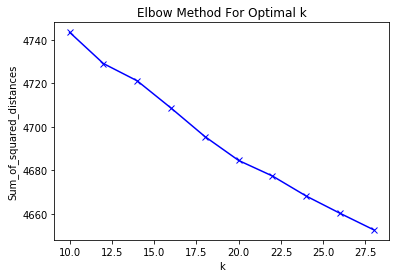

In [13]:
random.shuffle(data)
d1 = data[:5000]
dl=pd.DataFrame(data=d1, columns=['Job Title', 'Company','Location','Description'])
tvec = TfidfVectorizer(max_df=0.8, min_df=3, ngram_range=(1,3), stop_words=stop_words, tokenizer=tokenize)#limit max appearance of word 
tvs = tvec.fit_transform(dl['Description'])
shp = tvs.shape
Sum_of_squared_distances = []
K = range(10,30,2)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(tvs)
    Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [17]:
# #limit max appearance of word 
# tvec = TfidfVectorizer(max_df=0.8, min_df=0.3, ngram_range=(1,3), stop_words=stop_words, tokenizer=regstemtoken)
# tvs = tvec.fit_transform(dftok['Description'])
# featname = tvec.get_feature_names()
# print(tvs.shape)
# lst = [0]*158115
# for item in tvs:
#     lt = item.toarray()[0]
#     for i in range(0,(len(lt))):
#         out = lt[i]+lst[i]
#         lst[i] = out
# for s in range(0,(len(lst))):
#     lst[s] = lst[s]/21187
    
# dic = tvec.vocabulary_
# name = [None]*158115

# for key,value in dic.items():
#     val = int(value)
#     name[val]= key

(21187, 158115)


In [19]:
into = []
for u, y in zip(lst, name):
    into.append([y,u])
dfmean = pd.DataFrame(data=into, columns=['Vector', 'Mean TDIDF'])
dfmeanl200 = dfmean.nlargest(1000,'Mean TDIDF')
dfmeanl200.head(1000)
dfmeanl200.to_sql(name='CustomTokenTop1000', con=conn, if_exists='replace')

D:\Anaconda\lib\site-packages\pandas\core\generic.py:2130: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  dtype=dtype)


In [ ]:
print(len(featname))
# dftd = pd.DataFrame(data=tvs, columns=featname)
# dftd.head(5)
# wc = dfcount.mean().tolist()
# label = list(dfcount.columns.values)
# win = []
# for m,w in zip(wc,label):
#     ls = [w,m]
#     win.append(ls)
# dfwc = pd.DataFrame(data=win, columns= ['Word', 'Mean Appearance'])
# dfwcb = dfwc.nlargest(150, 'Mean Appearanace')

In [ ]:
# count_vect = CountVectorizer(stop_words = stop_words)
# dlist = [dfa, dfmle, dfde, dfbd, dfs]
# dout = []
# for df in dlist:
#     X = count_vect.fit_transform(df['Description'])
#     featname = count_vect.get_feature_names()
#     dfcount = pd.DataFrame(data=X.toarray(), columns=featname)
#     dout.append(dfcount)
# dtitle = ['Data Analyst Count Vector Top 50','Machine Learning Engineer Count Vector Top 50','Data Engineer Count Vector Top 50','Big Data Count Vector Top 50','Data Scientist Count Vector Top 50']
# for df,title in zip(dout, dtitle):
#     wordcomp = df.mean().tolist()
#     label = list(df.columns.values)
#     win = []
#     for m,w in zip(wordcomp,label):
#         ls = [w,m]
#         win.append(ls)
#     dfwc = pd.DataFrame(data=win, columns=['Word','Mean Appearance'])
#     dfwcb = dfwc.nlargest(50,'Mean Appearance')
#     dfwcb.to_sql(name=title, con =conn, if_exists='replace')
# #     cur.execute('CREATE TABLE IF NOT EXISTS [' + title + ']([Word] TEXT, [Mean Appearance] INTEGER, UNIQUE([Word]))')
# #     cur.execute('INSERT OR IGNORE INTO [' + title + ']([Word],[Mean Appearance]) VALUES(?,?)', (dfwcb['Word'],dfwcb['Mean Appearance']))